# Generate plots for differential expression simulation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 100)
import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from statsmodels.stats.moment_helpers import cov2corr
import string
from collections import OrderedDict
from matplotlib.lines import Line2D
import random

/tmp/ipykernel_3990464/3080105211.py:12: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [3]:
data_path = '/data_volume/memento/simulation/'

In [4]:
# plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'lightsteelblue'])


In [5]:
results = OrderedDict()


### Run memento - no replicate mode

In [45]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
%autoreload 2

In [60]:
import sys
sys.path.append('/home/ssm-user/Github/memento')

import memento.model.rna as rna
import memento.estimator.hypergeometric as hg
import memento.estimator.sample as samp
import memento.util as util

In [61]:
import logging
logging.basicConfig(
    format="%(asctime)s %(process)-7s %(levelname)-8s %(message)s",
    level=logging.INFO, 
    datefmt="%Y-%m-%d %H:%M:%S",
)
logging.captureWarnings(True)

In [62]:
q=0.1

In [87]:
adata = sc.read(data_path + 'de/anndata.h5ad')

adata.obs['q'] = q
adata.X = adata.X.astype(float)

rna.MementoRNA.setup_anndata(
        adata=adata,
        q_column='q',
        label_columns=['group','condition'],
        num_bins=30,
        trim_percent=1.0,
        shrinkage=0.0)

adata = adata[:, adata.X.mean(axis=0).A1 > 0.07]
model = rna.MementoRNA(adata=adata)

model.compute_estimate(
    estimand='mean',
    get_se=True,
    n_jobs=30,
)

2023-07-30 23:47:23 3990464 INFO     setup_anndata: creating groups
2023-07-30 23:47:23 3990464 INFO     setup_anndata: computing cell sizes
2023-07-30 23:47:23 3990464 INFO     compute_estimate: running estimators for ['sum', 'mean', 'log_mean', 'log1p_mean', 'se_sum', 'se_mean', 'se_log_mean', 'se_log1p_mean', 'total_umi', 'cell_count']
2023-07-30 23:47:23 3990464 INFO     compute_estimate: gene_list is None, using all genes in AnnData object
2023-07-30 23:47:23 3990464 INFO     compute_estimate: getting estimates for memento_group^raewc^ctrl using 30 parallel jobs
2023-07-30 23:47:31 3990464 INFO     compute_estimate: getting estimates for memento_group^raewc^stim using 30 parallel jobs
2023-07-30 23:47:40 3990464 INFO     compute_estimate: getting estimates for memento_group^mtmvf^ctrl using 30 parallel jobs
2023-07-30 23:47:45 3990464 INFO     compute_estimate: getting estimates for memento_group^mtmvf^stim using 30 parallel jobs
2023-07-30 23:47:45 3990464 WARNING  /home/ssm-user

In [ ]:
df = pd.DataFrame(index=adata.uns['memento']['groups'])
df['group'] = df.index.str.split('^').str[1]
df['condition'] = df.index.str.split('^').str[2]

cov_df = pd.get_dummies(df[['group']], drop_first=True).astype(float)
# cov_df -= cov_df.mean()
stim_df = (df[['condition']]=='stim').astype(float)
interaction_df = cov_df*stim_df[['condition']].values
interaction_df.columns=[f'interaction_{col}' for col in cov_df.columns]
cov_df = pd.concat([cov_df, interaction_df], axis=1)
cov_df = sm.add_constant(cov_df)
# cov_df = cov_df.iloc[:, [0]]

results['memento'] = model.differential_mean(
    covariates=cov_df, 
    treatments=stim_df,
    estimator='log_mean',
    family='WLS',
    verbose=0,
    n_jobs=5)

In [89]:
Z = pd.get_dummies(df[['group']], drop_first=False).values

In [90]:
for idx in range(Z.shape[0]):
    print(0.5*Z[[idx]]@Z[[idx]].T)

[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]
[[0.5]]


In [91]:
_, results['memento']['fdr'] = fdrcorrection(results['memento']['pval'])
results['memento'] = results['memento'][['coef', 'pval', 'fdr']]

In [92]:
results['memento'].head(5)

,coef,pval,fdr
gene,,,
gene_2,-0.021407,0.928490,0.996909
gene_5,0.447591,0.201308,0.883351
gene_6,0.124623,0.523010,0.972648
gene_8,-0.395381,0.369568,0.947438
gene_10,-0.052791,0.533928,0.974567


### Read results

In [93]:
# Read anndata object and setup results
# adata = sc.read(data_path + 'de/anndata.h5ad')

# Set up results holder

# Read edger
results['edger_lrt'] = pd.read_csv(data_path + 'de/edger_lrt.csv', index_col=0)[['logFC', 'PValue', 'FDR']]
results['edger_qlft'] = pd.read_csv(data_path + 'de/edger_qlft.csv', index_col=0)[['logFC', 'PValue', 'FDR']]



# Read t test
results['t'] = pd.read_csv(data_path + 'de/t.csv', index_col=0)[['coef', 'pval', 'fdr']]



### Make power vs FDR curve

In [94]:
# Get overlapping genes
genes = set(adata.var.index)
for method, result in results.items():
    results[method] = result.join(adata.var[['is_de']],how='inner')
    genes &= set(result.index)
genes = list(genes)
for method, result in results.items():
    results[method] = result.loc[genes]
    results[method].columns = ['coef', 'pval', 'fdr', 'is_de']

memento - fpr: 0.0421731123388582 - tpr : 0.6087551299589603 - thresh : 0.05
edger_lrt - fpr: 0.06970534069981583 - tpr : 0.9534883720930233 - thresh : 0.05
edger_qlft - fpr: 0.06906077348066299 - tpr : 0.9534883720930233 - thresh : 0.05
t - fpr: 0.04392265193370166 - tpr : 0.948016415868673 - thresh : 0.05


Text(0.5, 0, 'FDR')

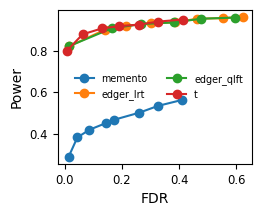

In [95]:
plt.figure(figsize=(2.5, 2))
# Print some statistics
n=8
thresholds = OrderedDict([
    ('memento',np.linspace(0.01, 0.5, n)),
    ('memento_wls',np.linspace(0.01, 0.1, n)),
    ('old_memento', np.linspace(0.01, 0.1, n)),
    ('t',np.linspace(0.01, 0.5, n-1)),
    ('edger_lrt',np.linspace(0.01, 0.5, n)),
    ('edger_qlft',np.linspace(0.01, 0.5, n-2))     
])
check_thresh = 0.05
for method, result in results.items():
    if method == 'old_memento':continue

    tpr = (result.query('is_de')['pval'] < check_thresh).mean()
    fpr = (result.query('~is_de')['pval'] < check_thresh).mean()
    print(f'{method} - fpr: {fpr} - tpr : {tpr} - thresh : {check_thresh}')

    fdr = []
    tpr = []
    sorted_result = result.sort_values('fdr')
    for thresh in thresholds[method]:

        hits = result.query(f'fdr < {thresh}')
        fdr.append(1-hits['is_de'].mean())
        tpr.append(hits['is_de'].sum()/result['is_de'].sum())
    plt.plot(fdr, tpr, '-o', label=method)
plt.legend(frameon=False, ncol=2, )
plt.ylabel('Power'); plt.xlabel('FDR')

memento - fpr: 0.0421731123388582 - tpr : 0.6087551299589603 - thresh : 0.05
edger_lrt - fpr: 0.06970534069981583 - tpr : 0.9534883720930233 - thresh : 0.05
edger_qlft - fpr: 0.06906077348066299 - tpr : 0.9534883720930233 - thresh : 0.05
t - fpr: 0.04392265193370166 - tpr : 0.948016415868673 - thresh : 0.05


Text(0.5, 0, 'FPR')

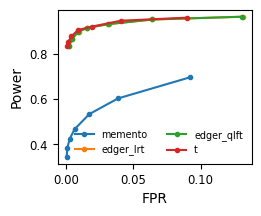

In [96]:
plt.figure(figsize=(2.5, 2))
# Print some statistics
n=8
thresholds = OrderedDict([
    ('memento',np.logspace(-3, -1, n-1)),
    ('memento_wls',np.linspace(0.001, 0.1, n)),
    ('old_memento', np.linspace(0.001, 0.1, n)),

    ('t',np.logspace(-3, -1, n-1)),
    ('edger_lrt',np.logspace(-3, -1., n-1)),
    ('edger_qlft',np.logspace(-3, -1, n-1))     
])
check_thresh = 0.05
for method, result in results.items():

    tpr = (result.query('is_de')['pval'] < check_thresh).mean()
    fpr = (result.query('~is_de')['pval'] < check_thresh).mean()
    print(f'{method} - fpr: {fpr} - tpr : {tpr} - thresh : {check_thresh}')

    fpr = []
    tpr = []
    sorted_result = result.sort_values('fdr')
    for thresh in thresholds[method]:

        hits = result.query(f'pval < {thresh}')
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
        tpr.append(hits['is_de'].sum()/result['is_de'].sum())
    plt.plot(fpr, tpr, '-o', label=method, markersize=3)
plt.legend(frameon=False, ncol=2, )
plt.ylabel('Power'); plt.xlabel('FPR')

### Make calibration curves

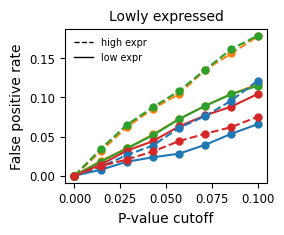

In [97]:
means = pd.DataFrame(adata.X.mean(axis=0).A1, index=adata.var.index)
means.columns=['mean']
plt.figure(figsize=(2.6,2))

# LOW EXPR genes
sig_thresholds = np.linspace(0, 0.1, n)

for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] < np.quantile(result['mean'], 0.1)]
    
    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
plt.ylabel('False positive rate')
plt.xlabel('P-value cutoff')
plt.title('Lowly expressed')

plt.gca().set_prop_cycle(None)

# HIGH EXPR genes
for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] > np.quantile(result['mean'], 0.9)]

    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '--o', markersize=5)
plt.rcParams['legend.handlelength'] = 0
plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0, 1.5), ncol=2)
plt.rcParams['legend.handlelength'] = 2
# plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
legend_elements = [Line2D([0], [0], color='k', lw=1, label='high expr', linestyle='--'),
                   Line2D([0], [0], color='k', lw=1, label='low expr')]
plt.legend(handles=legend_elements, frameon=False)


(1159, 5)
(1159, 5)
(1159, 5)
(1159, 5)


Text(0.5, 1.0, 'Highly expressed')

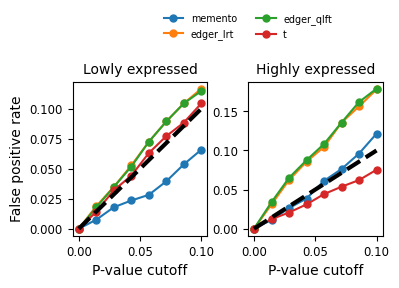

In [98]:
means = pd.DataFrame(adata.X.mean(axis=0).A1, index=adata.var.index)
means.columns=['mean']
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.3)

# LOW EXPR genes
plt.subplot(1, 2, 1);
sig_thresholds = np.linspace(0, 0.1, n)

for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] < np.quantile(result['mean'], 0.1)]
    print(result.shape)
    
    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
plt.ylabel('False positive rate')
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('Lowly expressed')

# HIGH EXPR genes
plt.subplot(1, 2, 2)
for method, result in results.items():
    result = result.join(means)
    result = result.loc[result['mean'] > np.quantile(result['mean'], 0.9)]

    fdr = []
    fpr = []
    
    sorted_result = result.sort_values('fdr')
    for thresh in sig_thresholds:

        fdr_hits = result.query(f'fdr < {thresh}')
        fpr_hits = result.query(f'pval < {thresh}')
        fdr.append(1-fdr_hits['is_de'].mean())
        fpr.append((result.query('~is_de')['pval'] < thresh).mean())
    plt.plot(sig_thresholds, fpr, '-o', label=method, markersize=5)
    plt.legend(frameon=False, loc='upper center', bbox_to_anchor=(0, 1.5), ncol=2)
plt.plot([0, 0.1], [0, 0.1], '--', color='k', lw=3)
plt.xlabel('P-value cutoff')
plt.title('Highly expressed')


# Old sections

### Debugging section

In [144]:
group = 'memento_group^ctrl'
barcodes = model.adata.uns['memento']['group_barcodes'][group]
gene_list = model.adata.var.index.tolist()

data = model.subset_matrix(barcodes, gene_list).tocsc() #CSC format is faster
sf = model.adata.obs.loc[barcodes]['memento_size_factor'].values
approx_sf = model.adata.obs.loc[barcodes]['memento_approx_size_factor'].values
q = model.adata.uns['memento']['group_q'][group]

In [187]:
group2 = 'memento_group^stim'
barcodes2 = model.adata.uns['memento']['group_barcodes'][group2]

data2 = model.subset_matrix(barcodes2, gene_list).tocsc() #CSC format is faster
sf2 = model.adata.obs.loc[barcodes2]['memento_size_factor'].values
approx_sf2 = model.adata.obs.loc[barcodes2]['memento_approx_size_factor'].values


In [275]:
tstat, pv = stats.ttest_ind(
    data/approx_sf.reshape(-1,1), 
    data2/approx_sf2.reshape(-1,1))
_, fdr = fdrcorrection(pv)
results['memento'] = pd.DataFrame(zip(tstat, pv, fdr), columns=['coef', 'pval', 'fdr'], index=gene_list)


In [378]:
tstat, pv = stats.ttest_ind_from_stats(
    (data/approx_sf.reshape(-1,1)).mean(axis=0).A1,
    (data/approx_sf.reshape(-1,1)).std(axis=0).A1,
    data.shape[0],
    (data2/approx_sf2.reshape(-1,1)).mean(axis=0).A1,
    (data2/approx_sf2.reshape(-1,1)).std(axis=0).A1,
    data2.shape[0],   
    equal_var=False,
)
_, fdr = fdrcorrection(pv)
results['memento'] = pd.DataFrame(zip(tstat, pv, fdr), columns=['coef', 'pval', 'fdr'], index=gene_list)


In [296]:
m1 = model.estimates['mean'].iloc[0, :]
m2 = model.estimates['mean'].iloc[1, :]
v1 = samp.sample_variance(data, approx_sf)
v2 = samp.sample_variance(data2, approx_sf2)
n1 = data.shape[0]
n2 = data.shape[0]

In [371]:
coef = samp.sample_mean(data2, approx_sf2) - samp.sample_mean(data, approx_sf)
sv1 =  samp.sample_variance(data, approx_sf)/data.shape[0]
sv2 = samp.sample_variance(data2, approx_sf2)/data2.shape[0]
se = np.sqrt(sv1 + sv2)
pv = 2*stats.norm.sf(np.absolute(coef/se))
_, fdr = fdrcorrection(pv)


results['memento'] = pd.DataFrame(zip(coef, pv, fdr), columns=['coef', 'pval', 'fdr'], index=gene_list)


In [314]:
idx = 8548
# idx = 0

In [315]:
a = hg.hg_sem_for_gene(data[:, idx], q, approx_sf, 1000, group, return_boot_samples=True)

<Axes: ylabel='Density'>

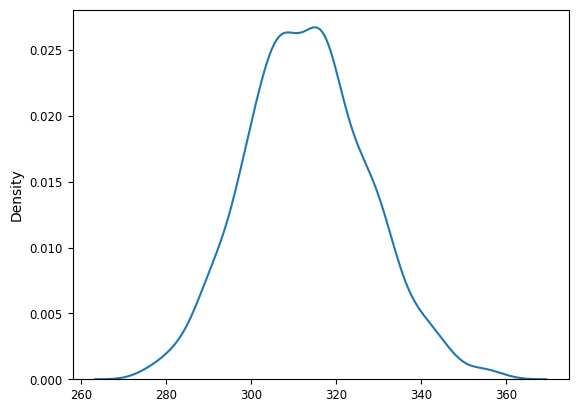

In [316]:
sns.kdeplot(a)

In [317]:
 hg.hg_sem_for_gene(data[:, idx], q, approx_sf, 1000, group, return_boot_samples=False)

(14.192574156448677,
 7991.134813478997,
 0.04525080069634406,
 0.04510661781260613)

In [318]:
s = samp.sample_variance(data, approx_sf)/data.shape[0]

In [319]:
np.sqrt(s[idx])

13.662617819397619